In [9]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

Dataset MNIST
    Number of datapoints: 60000
    Root location: ../Datasets
    Split: Train
    StandardTransform
Transform: ToTensor()
Dataset MNIST
    Number of datapoints: 10000
    Root location: ../Datasets
    Split: Test
    StandardTransform
Transform: ToTensor()


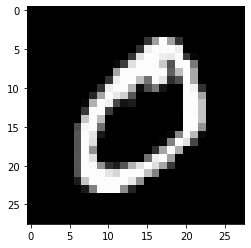

0


In [10]:
transform = transforms.ToTensor()
train_data = datasets.MNIST(root='../Datasets', train=True, download=True, transform=transform)
test_data = datasets.MNIST(root='../Datasets', train=False, download=True, transform=transform)
print(train_data)
print(test_data)
image, label = train_data[1]
plt.imshow(image.reshape(28,28), cmap='gray') # image is of 3d (1,28,28) need it in (28,28)
plt.show()
print(label)

In [11]:
train_data_loader = DataLoader(train_data, batch_size=20, shuffle=True)
test_data_loader = DataLoader(test_data, batch_size=20, shuffle=True)


In [12]:
class ConvolutionalNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 16, 3, 1)
        self.conv2 = nn.Conv2d(16, 32, 3, 1)
        self.fc1 = nn.Linear(5*5*32, 128)
        self.fc2 = nn.Linear(128, 32)
        self.fc3 = nn.Linear(32,10)

    def forward(self, X):
        X = F.relu(self.conv1(X))
        X = F.max_pool2d(X, 2, 2)
        X = F.relu(self.conv2(X))
        X = F.max_pool2d(X, 2, 2)
        X = X.view(-1, 5*5*32) # flattens it
        X = F.relu(self.fc1(X))
        X = F.relu(self.fc2(X))
        X = self.fc3(X)
        return F.log_softmax(X, dim=1)

In [13]:
torch.manual_seed(12345)
model = ConvolutionalNetwork()
model

ConvolutionalNetwork(
  (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=800, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=32, bias=True)
  (fc3): Linear(in_features=32, out_features=10, bias=True)
)

In [14]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [15]:
epochs = 5
train_losses = []
test_losses = []
train_correct = []
test_correct = []

for i in range(epochs):
    trn_corr = 0
    tst_corr = 0
    for b, (X_train, y_train) in enumerate(train_data_loader):
        b+=1
        optimizer.zero_grad()
        y_pred = model(X_train)
        loss = criterion(y_pred, y_train)
        trn_corr += (torch.max(y_pred.data, 1)[1] == y_train).sum()
        loss.backward()
        optimizer.step()

    print(f'epoch: {i:2}  loss: {loss.item():10.8f} accuracy: {trn_corr.item()*100/(20*b):7.3f}%')

    train_losses.append(loss.item())
    train_correct.append((trn_corr/b))

    with torch.no_grad():
        for b, (X_test, y_test) in enumerate(test_data_loader):
            b+=1
            y_val = model(X_test)
            predicted = torch.max(y_val.data, 1)[1]
            tst_corr += (predicted == y_test).sum()

    loss = criterion(y_val, y_test)
    test_losses.append(loss.item())
    test_correct.append((tst_corr/b))

epoch:  0 loss: 0.01395191 accuracy:  93.905%
epoch:  1 loss: 0.00263050 accuracy:  98.225%
epoch:  2 loss: 0.03380300 accuracy:  98.702%
epoch:  3 loss: 0.03574254 accuracy:  99.058%
epoch:  4 loss: 0.00071272 accuracy:  99.250%


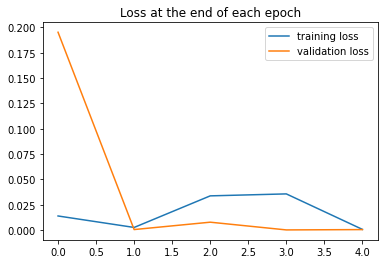

In [16]:
plt.plot(train_losses, label='training loss')
plt.plot(test_losses, label='validation loss')
plt.title('Loss at the end of each epoch')
plt.legend()
plt.show()

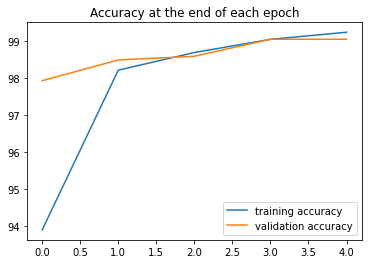

In [17]:
plt.plot(train_correct, label='training accuracy')
plt.plot(test_correct, label='validation accuracy')
plt.title('Accuracy at the end of each epoch')
plt.legend()
plt.show()